In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.max_colwidth', 3000)
pd.set_option("display.max_rows", 100000)

In [3]:
def read_pickle_files(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)


def plot_roc_curve(class_dict, y_preds, y_truth, get_auc=True):
    plt.figure(figsize=(12, 9))
    auc_dict = dict()
    for (idx, c_label) in enumerate(class_dict.values()):
        fpr, tpr, thresholds = roc_curve(y_truth.iloc[:, idx].astype(int), y_preds[:, idx])
        plt.plot(fpr, tpr, label="{}: [AUC: {:.03f}]".format(c_label, auc(fpr, tpr)))
        auc_dict[c_label] = auc(fpr, tpr)
    # plt.legend()
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # fig.savefig('trained_net.png')
    plt.show()

    return auc_dict


def save_model(model, filepath):
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
        
        
# def data_scaler(df):
#     scaler = StandardScaler()
#     df = pd.DataFrame(scaler.fit_transform(df))
#     return df

In [4]:
print("Reading Features Data from Drive...")
filepath = "df_resnet152_features.csv"
features_df = pd.read_csv(filepath, index_col=0)

print("Dropping Unnecessary Columns")
features_df.drop(columns=["disease_vec", "image_index"], axis=1, inplace=True)
print("Done!")

Reading Features Data from Drive...
Dropping Unnecessary Columns
Done!


In [5]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.259055,1.764044,0.074584,0.235642,0.729315,0.108479,1.196721,0.206394,0.257726,1.175031,...,0.165620,0.331340,0.249600,0.347991,0.708194,0.719252,1.259327,0.413690,0.642604,0.332446
1,0.994248,1.819007,0.115666,0.799520,0.788163,0.404541,1.057724,0.136437,0.008312,0.835848,...,0.180386,0.235418,0.400555,0.410541,0.943142,1.034511,0.557865,0.322591,0.694101,0.156991
2,1.352075,1.394869,0.021853,0.153628,0.574001,0.191191,1.074452,0.109366,0.518851,0.965034,...,0.065134,0.715820,0.225927,0.175372,1.016153,0.130930,0.748781,0.706917,0.569463,0.600405
3,1.055545,1.484014,0.090645,0.919076,0.670314,0.278388,0.838380,0.122276,0.055902,1.254084,...,0.095606,0.683062,1.286569,0.457071,0.796192,0.366520,1.321119,0.448143,0.465900,0.392211
4,1.286834,1.803985,0.310946,0.299076,0.874087,0.582390,1.219509,0.002486,0.211463,0.912122,...,0.111965,0.378083,0.669442,0.161419,0.766830,0.359261,0.930069,0.317765,0.953285,0.477477


In [6]:
print("Reading Class Dict...")
class_dict = read_pickle_files("class_dict_wo_NF.pkl")
classes = list(class_dict.values())
print("Done!")

Reading Class Dict...
Done!


In [7]:
classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [8]:
print("Reading Metadata...")
metadata = pd.read_csv("final_df_all_images_wo_NF_labels.csv")
print("Extracting Disease Label Columns...")
labels_df = metadata[classes]
del metadata
print("Done!")

Reading Metadata...
Extracting Disease Label Columns...
Done!


In [9]:
labels_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
test_split = 0.01
train_split = 1-test_split
print("Splitting Data into Train ({}%) and Test ({}%) ...".format(train_split*100, test_split*100))
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.05, random_state=101, shuffle=True)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
print("Done!")

Splitting Data into Train (99.0%) and Test (1.0%) ...
Done!


In [10]:
"""#gridsearch 

etc = ExtraTreesClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, random_state = 101) 

param_grid = { 
    'n_estimators': [200,500,700],
    'max_features': ['sqrt'],
    'max_depth' : [100],
    "min_samples_split": [2, 5, 10, 15], "min_samples_leaf": [1, 5],
    'criterion' :['gini', 'entropy']
}

CV_etc = GridSearchCV(estimator=etc, param_grid=param_grid, cv= 5, verbose=1)
CV_etc.fit(X_train, y_train)
print (CV_etc.best_params_)
"""

'#gridsearch \n\netc = ExtraTreesClassifier(n_jobs=-1,max_features= \'sqrt\' ,n_estimators=50, random_state = 101) \n\nparam_grid = { \n    \'n_estimators\': [200,500,700],\n    \'max_features\': [\'sqrt\'],\n    \'max_depth\' : [100],\n    "min_samples_split": [2, 5, 10, 15], "min_samples_leaf": [1, 5],\n    \'criterion\' :[\'gini\', \'entropy\']\n}\n\nCV_etc = GridSearchCV(estimator=etc, param_grid=param_grid, cv= 5, verbose=1)\nCV_etc.fit(X_train, y_train)\nprint (CV_etc.best_params_)\n'

Done!
Time Taken: 87.43930
Creating ROC Curve and computing AUC...


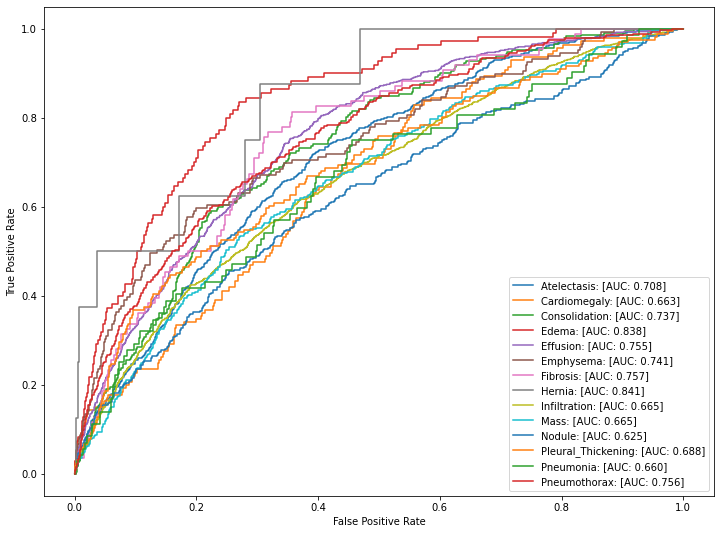

Done!


0.7212643038680521

In [11]:
start = time.time()
etc3 = ExtraTreesClassifier(n_jobs=-1,random_state=7, max_features='sqrt', n_estimators= 500, max_depth=100, criterion='gini',
                           min_samples_split = 200, min_samples_leaf = 200)

"""etc3 = ExtraTreesClassifier(n_jobs=-1,random_state=101, max_features='sqrt', n_estimators= 500, max_depth=100, criterion='gini',
                           min_samples_split = 5, min_samples_leaf = 5)"""
etc3.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))
y_preds_lg = etc3.predict_proba(X_test)

y_pred = np.array(y_preds_lg)
ypreds = np.transpose([pred for pred in y_pred])
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, ypreds[1,:], y_test, get_auc=True)
print("Done!")

np.array(list(auc_dict.values())).mean()

In [12]:
#save model
filepath = "etratree_72.sav"
save_model(etc3, filepath)

Evaluating Model on Train Set...
Creating ROC Curve and computing AUC...


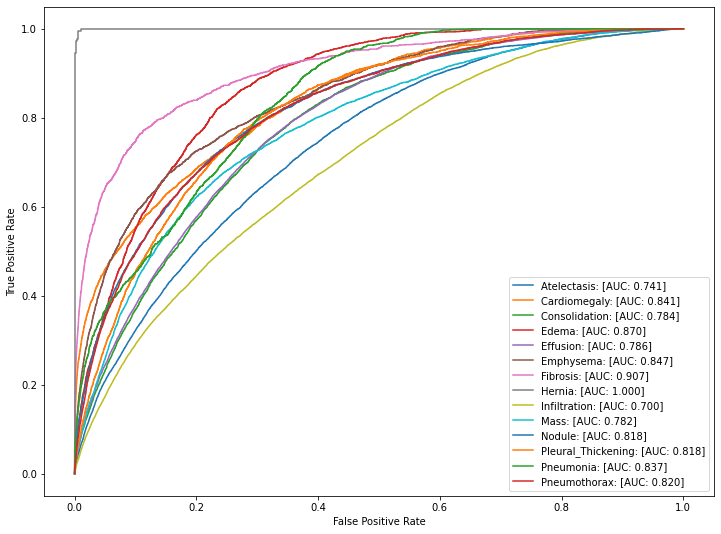

Done!


In [13]:
print("Evaluating Model on Train Set...")
y_preds = etc3.predict_proba(X_train)
y_pred = np.array(y_preds)
ypreds = np.transpose([pred for pred in y_pred])
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, ypreds[1,:], y_train, get_auc=True)
print("Done!")